***
# 1- Importing Libraries

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchviz import make_dot

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import pickle
import os

pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)  

# This dictionary will be used to save results.
result_of_all_cases = {}

***
# 2- Loading Data

In [2]:
directory_of_data = 'simulation_data/'
directory_of_machine_setting = os.path.join(directory_of_data, 'Parameter_Simulation_01.csv')

In [3]:
experiment_names = sorted([entry for entry in os.listdir(directory_of_data) if os.path.isdir(os.path.join(directory_of_data, entry))], 
                          key=lambda x: int(x.split('-')[1]))

In [4]:
def csv_file_path_to_dataframe(csv_file_path):

    # Read the first line of the CSV file to get the column names
    with open(csv_file_path, 'r') as file:
        column_names = file.readline().strip().split(';')

    # Read the CSV file into a DataFrame using the extracted column names
    df = pd.read_csv(csv_file_path, sep=';', skiprows=1, names=column_names)
    
    return df

In [5]:
machine_settings_dataframe = csv_file_path_to_dataframe(directory_of_machine_setting)
machine_settings_dataframe

,﻿No.,Diameter tube [mm],Wallthickness tube [mm],Mandrel extraction before bending end [],Collet boost [-],Clearance pressure die [mm]
0,1,21.7,0.8,0,0.95,0.0
1,2,21.7,0.8,0,0.95,-0.1
2,3,21.7,0.8,0,0.95,-0.2
3,4,21.7,0.8,0,0.90,0.0
4,5,21.7,0.8,0,0.90,-0.1
...,...,...,...,...,...,...
157,158,22.3,1.2,10,0.90,-0.1
158,159,22.3,1.2,10,0.90,-0.2
159,160,22.3,1.2,10,0.85,0.0
160,161,22.3,1.2,10,0.85,-0.1


In [6]:
# To hold the result rows
result_rows = []

for i, row in machine_settings_dataframe.iterrows():

    simulation_geometry_path= os.path.join(directory_of_data, experiment_names[i], experiment_names[i] + '_geometry_after_springback.csv')

    simulation_geometry_result = csv_file_path_to_dataframe(simulation_geometry_path)
    
    # Convert the row to a one-row DataFrame for cross join
    simulation_setting_row = pd.DataFrame([row])
    
    # Cross join with the right dataframe
    merged = simulation_setting_row.merge(simulation_geometry_result, how='cross')
    
    # Append result
    result_rows.append(merged)

# Concatenate all merged results
settings_and_results_table = pd.concat(result_rows, ignore_index=True)
settings_and_results_table.columns = ['SimNo', 
                                      'DiameterTube', 'WallthicknessTube', 'MandrelExtractionBeforeBendingEnd', 'ColletBoost', 'ClearancePressureDie', 'Angle', 
                                      'SecondaryAxis', 'MainAxis', 'OutOfRoundness', 'Collapse']
settings_and_results_table

,SimNo,DiameterTube,WallthicknessTube,MandrelExtractionBeforeBendingEnd,ColletBoost,ClearancePressureDie,Angle,SecondaryAxis,MainAxis,OutOfRoundness,Collapse
0,1.0,21.7,0.8,0.0,0.95,0.0,0.00,20.989653,20.709006,0.013428,-0.750156
1,1.0,21.7,0.8,0.0,0.95,0.0,1.00,21.047345,20.583817,0.022178,-0.756952
2,1.0,21.7,0.8,0.0,0.95,0.0,2.00,21.074356,20.494895,0.027725,-0.759098
3,1.0,21.7,0.8,0.0,0.95,0.0,3.00,21.084474,20.508608,0.027553,-0.760691
4,1.0,21.7,0.8,0.0,0.95,0.0,4.00,21.081434,20.562734,0.024818,-0.765176
...,...,...,...,...,...,...,...,...,...,...,...
14532,162.0,22.3,1.2,10.0,0.85,-0.2,84.00,21.129769,20.854198,0.013060,-0.530644
14533,162.0,22.3,1.2,10.0,0.85,-0.2,85.00,21.120086,20.849323,0.012832,-0.519528
14534,162.0,22.3,1.2,10.0,0.85,-0.2,86.00,21.136285,20.844171,0.013844,-0.510575
14535,162.0,22.3,1.2,10.0,0.85,-0.2,87.00,21.135829,20.843278,0.013865,-0.511617


In [7]:
dataframes_dict = {
    'machine_settings_dataframe': machine_settings_dataframe,
    'settings_and_results_table': settings_and_results_table
}

# Save the dictionary to a .pkl file
with open('dataframes_dict.pkl', 'wb') as f:
    pickle.dump(dataframes_dict, f)

In [11]:
"""
# Load the dictionary from the .pkl file
with open('dataframes_dict.pkl', 'rb') as f:
    loaded_dataframes_dict = pickle.load(f)

# Access the DataFrames using the keys
machine_settings_dataframe_loaded = loaded_dataframes_dict['machine_settings_dataframe']
settings_and_results_table_loaded = loaded_dataframes_dict['settings_and_results_table']
"""

"\n# Load the dictionary from the .pkl file\nwith open('dataframes_dict.pkl', 'rb') as f:\n    loaded_dataframes_dict = pickle.load(f)\n\n# Access the DataFrames using the keys\nmachine_settings_dataframe_loaded = loaded_dataframes_dict['machine_settings_dataframe']\nsettings_and_results_table_loaded = loaded_dataframes_dict['settings_and_results_table']\n"

In [12]:
# Features and target columns (x, and y | input of model, output of model)
features = ['DiameterTube', 'WallthicknessTube', 'MandrelExtractionBeforeBendingEnd','ColletBoost', 'ClearancePressureDie', 'Angle']
targets = ['SecondaryAxis', 'MainAxis', 'OutOfRoundness', 'Collapse']

***
# 3- Case- 1 RF Performance
## 3.1- Data Splitting (Random 20%):

In [13]:
# Set a random seed for reproducibility (optional but recommended)
test_df = settings_and_results_table.sample(frac=0.2, random_state=42)

# Drop test set from the original to create training set
train_df = settings_and_results_table.drop(test_df.index)

test_df_input_data_X = test_df[features]
test_df_input_labels_y = test_df[targets]

train_df_input_data_X = train_df[features]
train_df_input_labels_y = train_df[targets]

# Check sizes
print(train_df_input_data_X.shape, train_df_input_labels_y.shape, test_df_input_data_X.shape, test_df_input_labels_y.shape)

(11630, 6) (11630, 4) (2907, 6) (2907, 4)


## 3.2- Model Training:

In [14]:
# Train model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
model.fit(train_df_input_data_X, train_df_input_labels_y)

# Predict
y_pred = model.predict(test_df_input_data_X)


mae = mean_absolute_error(test_df_input_labels_y, y_pred, multioutput='raw_values')

mse = mean_squared_error(test_df_input_labels_y, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)

r2 = r2_score(test_df_input_labels_y, y_pred, multioutput='raw_values')


result_of_this_case = {}

# Display per target variable
for i, var in enumerate(targets):
    print(f"\n{var}:")
    print(f"  MAE : {mae[i]:.4f}")
    print(f"  MSE : {mse[i]:.4f}")
    print(f"  RMSE: {rmse[i]:.4f}")
    print(f"  R²  : {r2[i]:.4f}")

    result_of_this_case[var] = {'MAE': f"{mae[i]:.4f}", 'MSE': f"{mse[i]:.4f}", 'RMSE': f"{rmse[i]:.4f}", 'R²': f"{r2[i]:.4f}"}

result_of_all_cases["random_shuffel_RF"] = result_of_this_case


SecondaryAxis:
  MAE : 0.0061
  MSE : 0.0001
  RMSE: 0.0088
  R²  : 0.9986

MainAxis:
  MAE : 0.0161
  MSE : 0.0013
  RMSE: 0.0367
  R²  : 0.9859

OutOfRoundness:
  MAE : 0.0009
  MSE : 0.0000
  RMSE: 0.0017
  R²  : 0.9923

Collapse:
  MAE : 0.0142
  MSE : 0.0004
  RMSE: 0.0201
  R²  : 0.9985


***
# 4- Case-2 - RF Performance

## 4.1- Data Splitting (Random 20% of simulations):

In [15]:
# Step 1: Get unique simulation IDs
unique_sims = settings_and_results_table['SimNo'].unique()

# Step 2: Split simulation IDs into train/test (80% train, 20% test)
train_sims, test_sims = train_test_split(unique_sims, test_size=0.2, random_state=42)

# Step 3: Create train and test DataFrames
train_df = settings_and_results_table[settings_and_results_table['SimNo'].isin(train_sims)]
test_df = settings_and_results_table[settings_and_results_table['SimNo'].isin(test_sims)]

# Step 4: Split into features (X) and targets (y)
train_X = train_df[features]
train_y = train_df[targets]
test_X = test_df[features]
test_y = test_df[targets]

## 4.2- Model Training:

In [16]:
# Step 5: Train Random Forest model
base_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model = MultiOutputRegressor(base_model)
model.fit(train_X, train_y)

# Step 6: Predict and evaluate
y_pred = model.predict(test_X)

# Metrics
mae = mean_absolute_error(test_y, y_pred, multioutput='raw_values')

mse = mean_squared_error(test_y, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)

r2 = r2_score(test_y, y_pred, multioutput='raw_values')

# Print results per target
print(f"\nEvaluation on unseen simulations ({len(test_sims)} simulations):")

result_of_this_case = {}

# Display per target variable
for i, var in enumerate(targets):
    print(f"\n{var}:")
    print(f"  MAE : {mae[i]:.4f}")
    print(f"  MSE : {mse[i]:.4f}")
    print(f"  RMSE: {rmse[i]:.4f}")
    print(f"  R²  : {r2[i]:.4f}")

    result_of_this_case[var] = {'MAE': f"{mae[i]:.4f}", 'MSE': f"{mse[i]:.4f}", 'RMSE': f"{rmse[i]:.4f}", 'R²': f"{r2[i]:.4f}"}

result_of_all_cases["random_unseen_simulation_RF"] = result_of_this_case


Evaluation on unseen simulations (33 simulations):

SecondaryAxis:
  MAE : 0.0226
  MSE : 0.0016
  RMSE: 0.0399
  R²  : 0.9713

MainAxis:
  MAE : 0.0337
  MSE : 0.0069
  RMSE: 0.0829
  R²  : 0.9221

OutOfRoundness:
  MAE : 0.0022
  MSE : 0.0000
  RMSE: 0.0050
  R²  : 0.9281

Collapse:
  MAE : 0.0685
  MSE : 0.0137
  RMSE: 0.1171
  R²  : 0.9567


***
# 5- Feature Importance Analysis:

## 5.1- Average Feature Importance Across All Targets

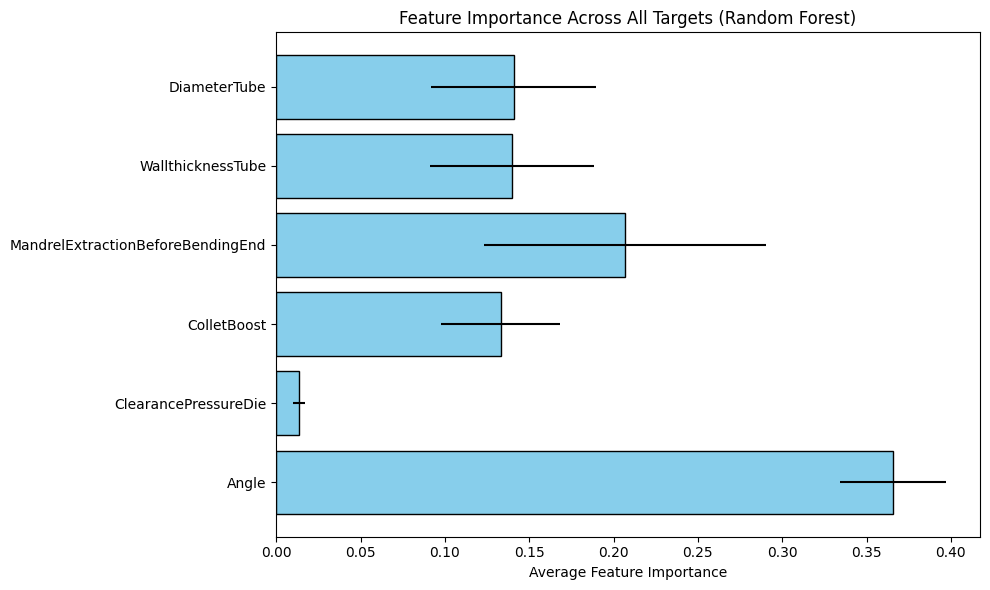

In [17]:
# Collect feature importances from each individual regressor
importances = np.array([est.feature_importances_ for est in model.estimators_])

# Average across all outputs
mean_importances = np.mean(importances, axis=0)
std_importances = np.std(importances, axis=0)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, mean_importances, xerr=std_importances, color='skyblue', edgecolor='black')
plt.xlabel("Average Feature Importance")
plt.title("Feature Importance Across All Targets (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5.2- Feature Importance per Target Variable

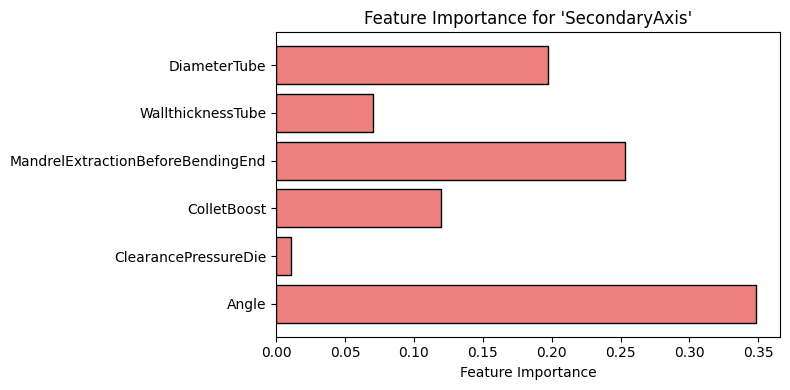

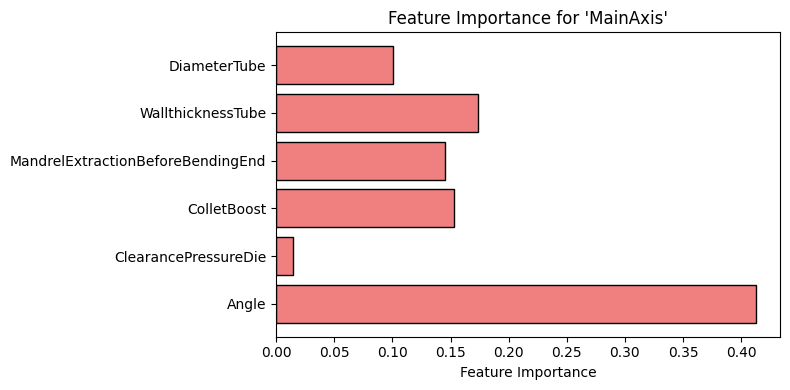

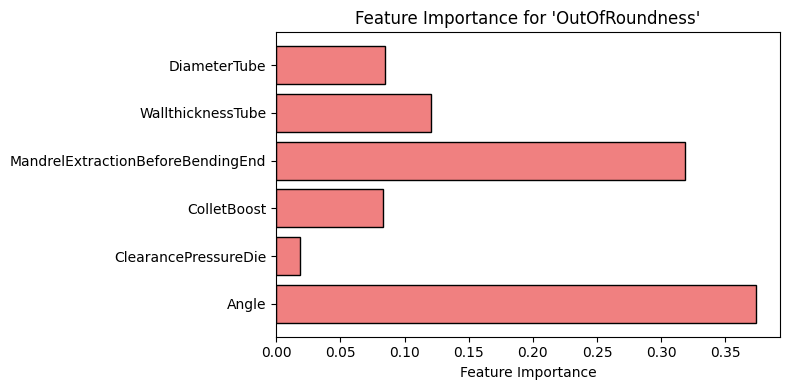

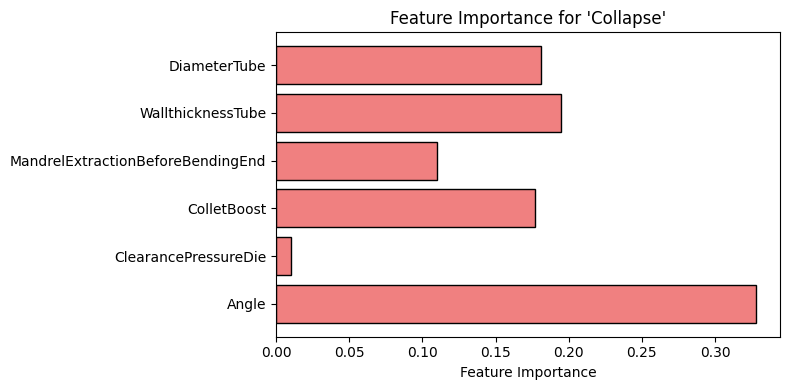

In [18]:
for i, target in enumerate(targets):
    importances = model.estimators_[i].feature_importances_
    
    plt.figure(figsize=(8, 4))
    plt.barh(features, importances, color='lightcoral', edgecolor='black')
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance for '{target}'")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

***
# 5- Case-3 - RF Performance with KMeans based Data Splitting

## 5.1- Data Splitting with Extream Hyperparameter Values

In [19]:
# Simulate the dataframe based on your description
np.random.seed(42)
n_samples = 162

# Standardize the hyperparameter columns
features = machine_settings_dataframe.columns[1:]  # exclude 'No.'
scaler = StandardScaler()
scaled_features = scaler.fit_transform(machine_settings_dataframe[features])

# Perform KMeans clustering (e.g., with 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
machine_settings_dataframe['Cluster'] = kmeans.fit_predict(scaled_features)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
machine_settings_dataframe['PCA1'] = pca_components[:, 0]
machine_settings_dataframe['PCA2'] = pca_components[:, 1]

In [20]:
result_of_all_cases["kmeans_clustered_unseen_simulation_RF"] = {}
cluster_list = list(np.unique(machine_settings_dataframe.Cluster.values))

for testing_cluster in cluster_list:

    # Prepare testing cluster:
    testing_df = machine_settings_dataframe[machine_settings_dataframe.Cluster == testing_cluster]

    # Take cluster to be trained:
    training_clusters = [cluster for cluster in cluster_list if cluster != testing_cluster]

    
    training_df1 = machine_settings_dataframe[machine_settings_dataframe.Cluster == training_clusters[0]]
    training_df2 = machine_settings_dataframe[machine_settings_dataframe.Cluster == training_clusters[1]]

    training_df = pd.concat([training_df1, training_df2])

    del training_df1, training_df2

    testing_data = settings_and_results_table[settings_and_results_table['SimNo'].isin(list(testing_df[testing_df.columns[0]].values))]

    test_X = testing_data[testing_data.columns[1:-4]]
    test_y = testing_data[testing_data.columns[7:]]

    training_data = settings_and_results_table[settings_and_results_table['SimNo'].isin(list(training_df[training_df.columns[0]].values))]

    train_X = training_data[training_data.columns[1:-4]]
    train_y = training_data[training_data.columns[7:]]

    """ RF Training """
    # Step 5: Train Random Forest model
    base_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model = MultiOutputRegressor(base_model)
    model.fit(train_X, train_y)

    # Step 6: Predict and evaluate
    y_pred = model.predict(test_X)

    # Metrics
    mae = mean_absolute_error(test_y, y_pred, multioutput='raw_values')
    mse = mean_squared_error(test_y, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    r2 = r2_score(test_y, y_pred, multioutput='raw_values')

    # Print results per target
    print(f"\nEvaluation executed on clustered {len(np.unique(testing_data.SimNo.values))} unseen simulations:")

    result_of_this_clusters = {}
    result_of_this_case = {}
    
    # Display per target variable
    for i, var in enumerate(targets):
        print(f"\n{var}:")
        print(f"  MAE : {mae[i]:.4f}")
        print(f"  MSE : {mse[i]:.4f}")
        print(f"  RMSE: {rmse[i]:.4f}")
        print(f"  R²  : {r2[i]:.4f}")
    
        result_of_this_case[var] = {'MAE': f"{mae[i]:.4f}", 'MSE': f"{mse[i]:.4f}", 'RMSE': f"{rmse[i]:.4f}", 'R²': f"{r2[i]:.4f}"}
       
    result_of_all_cases["kmeans_clustered_unseen_simulation_RF"][f'Cluster_{testing_cluster}'] = result_of_this_case



cluster_all_df = pd.DataFrame()

metrics = ['MAE', 'MSE', 'RMSE', 'R²']

for cluster in list(result_of_all_cases['kmeans_clustered_unseen_simulation_RF'].keys()):

    cluster_df = pd.DataFrame()
    
    for target in targets:
        for metric in metrics:

            cluster_df.at[metric, target] = result_of_all_cases['kmeans_clustered_unseen_simulation_RF'][cluster][target][metric]

    cluster_all_df = pd.concat([cluster_all_df, cluster_df])

# Step 1: Ensure all values are numeric (convert strings to floats)
cluster_all_df = cluster_all_df.apply(pd.to_numeric, errors='coerce')

# Step 2: Group by the index (e.g., MAE, MSE, etc.) and take the mean
average_df = cluster_all_df.groupby(cluster_all_df.index).mean()

# Step 3: Optional - reorder the rows if needed
average_df = average_df.loc[["MAE", "MSE", "RMSE", "R²"]]

# Round to 4 decimal places and convert to strings
rounded_df = average_df.round(4).astype(str)

# Filter to include only the desired metrics (remove MSE)
filtered_df = rounded_df.loc[["MAE", "MSE", "RMSE", "R²"]]

# Transpose and convert to nested dictionary
result_dict = filtered_df.to_dict()

result_of_all_cases['kmeans_clustered_unseen_simulation_RF'] = result_dict


Evaluation executed on clustered 57 unseen simulations:

SecondaryAxis:
  MAE : 0.0235
  MSE : 0.0012
  RMSE: 0.0349
  R²  : 0.9596

MainAxis:
  MAE : 0.0263
  MSE : 0.0028
  RMSE: 0.0529
  R²  : 0.9489

OutOfRoundness:
  MAE : 0.0018
  MSE : 0.0000
  RMSE: 0.0029
  R²  : 0.9619

Collapse:
  MAE : 0.0534
  MSE : 0.0064
  RMSE: 0.0801
  R²  : 0.9734

Evaluation executed on clustered 54 unseen simulations:

SecondaryAxis:
  MAE : 0.0202
  MSE : 0.0009
  RMSE: 0.0301
  R²  : 0.9730

MainAxis:
  MAE : 0.0309
  MSE : 0.0039
  RMSE: 0.0622
  R²  : 0.9480

OutOfRoundness:
  MAE : 0.0027
  MSE : 0.0000
  RMSE: 0.0045
  R²  : 0.9280

Collapse:
  MAE : 0.0566
  MSE : 0.0094
  RMSE: 0.0970
  R²  : 0.9639

Evaluation executed on clustered 51 unseen simulations:

SecondaryAxis:
  MAE : 0.1799
  MSE : 0.0512
  RMSE: 0.2264
  R²  : 0.3805

MainAxis:
  MAE : 0.1108
  MSE : 0.0330
  RMSE: 0.1816
  R²  : 0.7505

OutOfRoundness:
  MAE : 0.0095
  MSE : 0.0002
  RMSE: 0.0126
  R²  : 0.7289

Collapse:
  MA

***
# Comparison of Random Unseen vs Clustered Unseen

In [21]:
dict1 = result_of_all_cases['random_unseen_simulation_RF']
dict2 = result_of_all_cases['kmeans_clustered_unseen_simulation_RF']

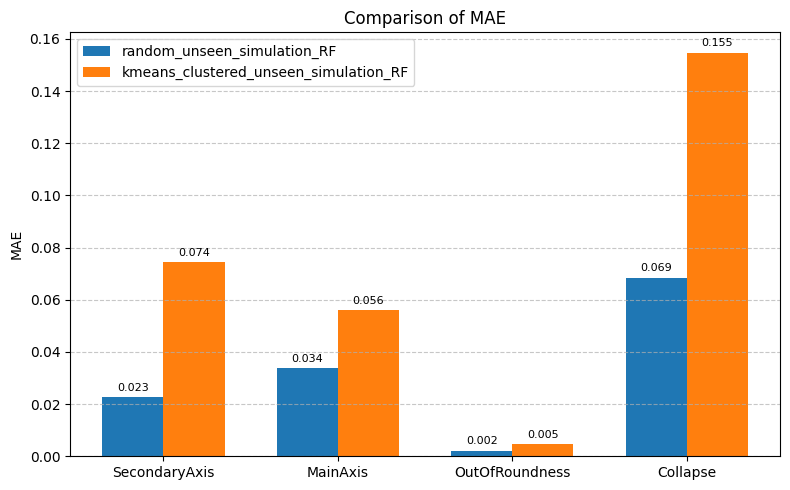

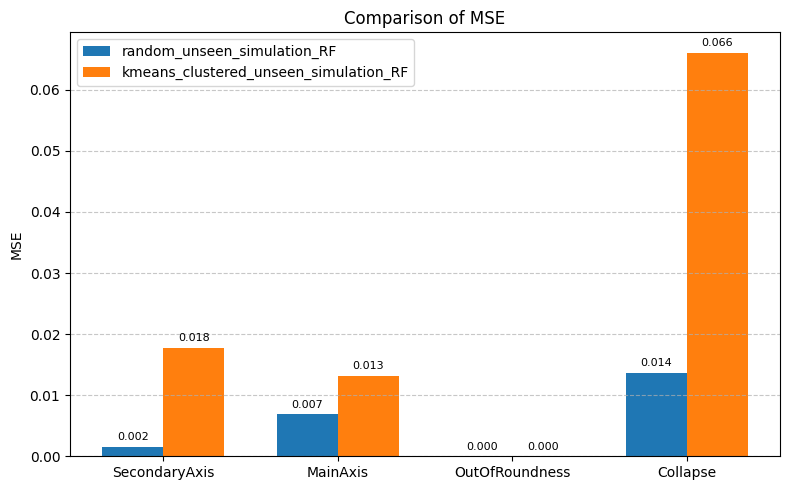

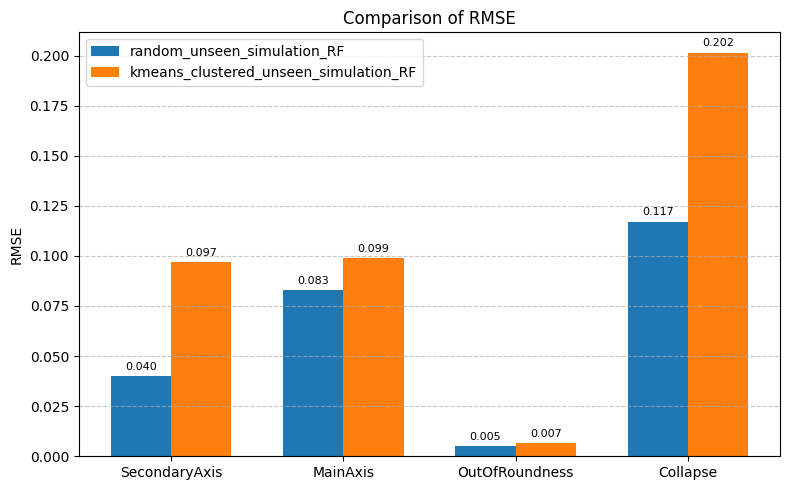

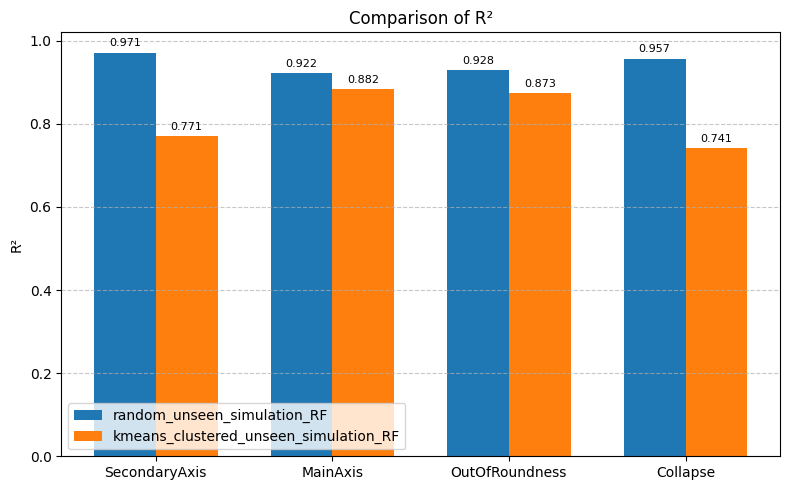

In [22]:
# Convert string values to floats
for d in [dict1, dict2]:
    for k1 in d:
        for k2 in d[k1]:
            d[k1][k2] = float(d[k1][k2])

# Get common axes and metrics
axes = list(dict1.keys())
metrics = list(next(iter(dict1.values())).keys())

# Plotting
x = np.arange(len(axes))  # the label locations
width = 0.35  # the width of the bars

for metric in metrics:
    values1 = [dict1[axis][metric] for axis in axes]
    values2 = [dict2[axis][metric] for axis in axes]

    fig, ax = plt.subplots(figsize=(8, 5))
    rects1 = ax.bar(x - width/2, values1, width, label='random_unseen_simulation_RF')
    rects2 = ax.bar(x + width/2, values2, width, label='kmeans_clustered_unseen_simulation_RF')

    # Labels & formatting
    ax.set_ylabel(metric)
    ax.set_title(f'Comparison of {metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(axes)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Annotate bars with values
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

***
# 6- MLP Case

## 6.1- Normalizing & scaling dataset

In [24]:
train_df

,SimNo,DiameterTube,WallthicknessTube,MandrelExtractionBeforeBendingEnd,ColletBoost,ClearancePressureDie,Angle,SecondaryAxis,MainAxis,OutOfRoundness,Collapse
0,1.0,21.7,0.8,0.0,0.95,0.0,0.00,20.989653,20.709006,0.013428,-0.750156
1,1.0,21.7,0.8,0.0,0.95,0.0,1.00,21.047345,20.583817,0.022178,-0.756952
2,1.0,21.7,0.8,0.0,0.95,0.0,2.00,21.074356,20.494895,0.027725,-0.759098
3,1.0,21.7,0.8,0.0,0.95,0.0,3.00,21.084474,20.508608,0.027553,-0.760691
4,1.0,21.7,0.8,0.0,0.95,0.0,4.00,21.081434,20.562734,0.024818,-0.765176
...,...,...,...,...,...,...,...,...,...,...,...
14532,162.0,22.3,1.2,10.0,0.85,-0.2,84.00,21.129769,20.854198,0.013060,-0.530644
14533,162.0,22.3,1.2,10.0,0.85,-0.2,85.00,21.120086,20.849323,0.012832,-0.519528
14534,162.0,22.3,1.2,10.0,0.85,-0.2,86.00,21.136285,20.844171,0.013844,-0.510575
14535,162.0,22.3,1.2,10.0,0.85,-0.2,87.00,21.135829,20.843278,0.013865,-0.511617


In [25]:
# Features and target columns (x, and y | input of model, output of model)
features = ['DiameterTube', 'WallthicknessTube', 'MandrelExtractionBeforeBendingEnd','ColletBoost', 'ClearancePressureDie', 'Angle']
targets = ['SecondaryAxis', 'MainAxis', 'OutOfRoundness', 'Collapse']

# Step 1: Get unique simulation IDs
unique_sims = settings_and_results_table['SimNo'].unique()

# Step 2: Split simulation IDs into train/test (80% train, 20% test)
train_sims, test_sims = train_test_split(unique_sims, test_size=0.2, random_state=42)

# Step 3: Create train and test DataFrames
train_df = settings_and_results_table[settings_and_results_table['SimNo'].isin(train_sims)]
test_df = settings_and_results_table[settings_and_results_table['SimNo'].isin(test_sims)]

# Step 4: Split into features (X) and targets (y)
train_X = train_df[features]
train_y = train_df[targets]
test_X = test_df[features]
test_y = test_df[targets]

# Convert pandas to numpy
X_train_np = train_X.to_numpy()
y_train_np = train_y.to_numpy()
X_test_np = test_X.to_numpy()
y_test_np = test_y.to_numpy()

# Normalize inputs
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_np)
X_test_scaled = scaler_X.transform(X_test_np)

# Optionally scale outputs too
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_np)
y_test_scaled = scaler_y.transform(y_test_np)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Create Datasets and Loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## 6.2- Model architecture

In [26]:
class MLP(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, output_dim=4):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

## 6.3- Saving model architecture in png

In [27]:
# Dummy input to visualize the model
dummy_input = torch.randn(1, 6)  # (batch_size, input_dim)

model = MLP()  # or your trained model
output = model(dummy_input)

# Create and render graph
make_dot(output, params=dict(model.named_parameters())).render("mlp_architecture", format="png")

'mlp_architecture.png'

## 6.4- Training

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50 # 5000

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 10/50, Loss: 29.9379
Epoch 20/50, Loss: 26.7073
Epoch 30/50, Loss: 25.0186
Epoch 40/50, Loss: 23.6230
Epoch 50/50, Loss: 21.7570


## 6.5- Model evaluation

In [31]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.to(device)).cpu()

# Inverse transform predictions and true labels
y_pred_np = scaler_y.inverse_transform(y_pred_tensor.numpy())
y_true_np = scaler_y.inverse_transform(y_test_tensor.numpy())

# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_true_np, y_pred_np, multioutput='raw_values')
mae = mean_absolute_error(y_true_np, y_pred_np, multioutput='raw_values')
rmse = np.sqrt(mse)
r2 = r2_score(y_true_np, y_pred_np, multioutput='raw_values')


result_of_this_case = {}

for i, target in enumerate(train_y.columns):
    print(f"\n{target}:")
    print(f"  MAE : {mae[i]:.4f}")
    print(f"  MSE : {mse[i]:.4f}")
    print(f"  RMSE: {rmse[i]:.4f}")
    print(f"  R²  : {r2[i]:.4f}")

    result_of_this_case[target] = {'MAE': f"{mae[i]:.4f}", 'MSE': f"{mse[i]:.4f}", 'MSE': f"{mse[i]:.4f}", 'RMSE': f"{rmse[i]:.4f}", 'R²': f"{r2[i]:.4f}"}

result_of_all_cases["random_unseen_simulation_MLP"] = result_of_this_case


SecondaryAxis:
  MAE : 0.0413
  MSE : 0.0031
  RMSE: 0.0558
  R²  : 0.9436

MainAxis:
  MAE : 0.1037
  MSE : 0.0286
  RMSE: 0.1691
  R²  : 0.6759

OutOfRoundness:
  MAE : 0.0058
  MSE : 0.0001
  RMSE: 0.0086
  R²  : 0.7879

Collapse:
  MAE : 0.0918
  MSE : 0.0144
  RMSE: 0.1200
  R²  : 0.9545


## 6.6- Result Comparison, MLP vs RF

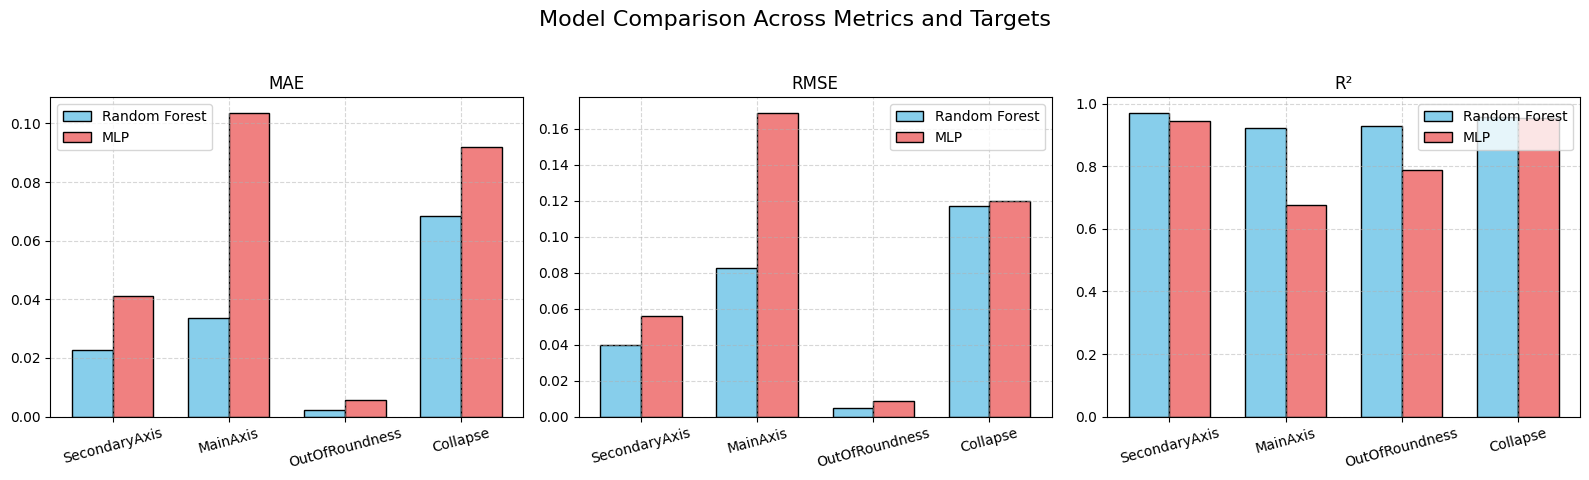

In [32]:
rf_metrics = result_of_all_cases['random_unseen_simulation_RF']
mlp_metrics = result_of_all_cases['random_unseen_simulation_MLP']

# Define the targets and metrics
targets = ['SecondaryAxis', 'MainAxis', 'OutOfRoundness', 'Collapse']
metrics = ['MAE', 'RMSE', 'R²']

x = np.arange(len(targets))  # the label locations
width = 0.35  # the width of the bars

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    rf_vals = [float(rf_metrics[target][metric]) for target in targets]
    mlp_vals = [float(mlp_metrics[target][metric]) for target in targets]

    ax.bar(x - width/2, rf_vals, width, label='Random Forest', color='skyblue', edgecolor='black')
    ax.bar(x + width/2, mlp_vals, width, label='MLP', color='lightcoral', edgecolor='black')

    ax.set_title(f'{metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(targets, rotation=15)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

fig.suptitle('Model Comparison Across Metrics and Targets', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

***
# 7- TabNet 

In [33]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np


# Scale inputs and outputs
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(train_X)
X_test_scaled = scaler_X.transform(test_X)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(train_y)
y_test_scaled = scaler_y.transform(test_y)

X_train_np = np.array(X_train_scaled)
y_train_np = np.array(y_train_scaled)
X_test_np = np.array(X_test_scaled)
y_test_np = np.array(y_test_scaled)

In [30]:
tabnet_model = TabNetRegressor()

tabnet_model.fit(
    X_train=X_train_np, y_train=y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_metric=['rmse'],
    max_epochs=5000,
    patience=1000,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


/home/zoz/.local/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10336 | val_0_rmse: 0.87795 |  0:00:00s
epoch 1  | loss: 0.5781  | val_0_rmse: 0.79938 |  0:00:01s
epoch 2  | loss: 0.45229 | val_0_rmse: 0.70436 |  0:00:01s
epoch 3  | loss: 0.39303 | val_0_rmse: 0.61982 |  0:00:01s
epoch 4  | loss: 0.35562 | val_0_rmse: 0.57592 |  0:00:02s
epoch 5  | loss: 0.32073 | val_0_rmse: 0.54389 |  0:00:02s
epoch 6  | loss: 0.29484 | val_0_rmse: 0.52381 |  0:00:02s
epoch 7  | loss: 0.27115 | val_0_rmse: 0.51373 |  0:00:02s
epoch 8  | loss: 0.26185 | val_0_rmse: 0.51087 |  0:00:03s
epoch 9  | loss: 0.24851 | val_0_rmse: 0.49534 |  0:00:03s
epoch 10 | loss: 0.24401 | val_0_rmse: 0.49263 |  0:00:03s
epoch 11 | loss: 0.23632 | val_0_rmse: 0.48686 |  0:00:04s
epoch 12 | loss: 0.22554 | val_0_rmse: 0.46954 |  0:00:04s
epoch 13 | loss: 0.22349 | val_0_rmse: 0.46064 |  0:00:04s
epoch 14 | loss: 0.2196  | val_0_rmse: 0.47393 |  0:00:05s
epoch 15 | loss: 0.21698 | val_0_rmse: 0.44963 |  0:00:05s
epoch 16 | loss: 0.21499 | val_0_rmse: 0.4941  |  0:00:0

/home/zoz/.local/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [34]:
# Predict
y_pred_scaled = tabnet_model.predict(X_test_np)

# Inverse scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_np)

# Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
r2 = r2_score(y_true, y_pred, multioutput='raw_values')

result_of_this_case = {}

for i, target in enumerate(train_y.columns):
    print(f"\n{target}:")
    print(f"  MAE : {mae[i]:.4f}")
    print(f"  RMSE: {rmse[i]:.4f}")
    print(f"  R²  : {r2[i]:.4f}")

    result_of_this_case[target] = {'MAE': f"{mae[i]:.4f}", 'RMSE': f"{rmse[i]:.4f}", 'R²': f"{r2[i]:.4f}"}

result_of_all_cases["random_unseen_simulation_TabNet"] = result_of_this_case


SecondaryAxis:
  MAE : 0.0251
  RMSE: 0.0349
  R²  : 0.9780

MainAxis:
  MAE : 0.0365
  RMSE: 0.0583
  R²  : 0.9615

OutOfRoundness:
  MAE : 0.0020
  RMSE: 0.0029
  R²  : 0.9756

Collapse:
  MAE : 0.0567
  RMSE: 0.0803
  R²  : 0.9796


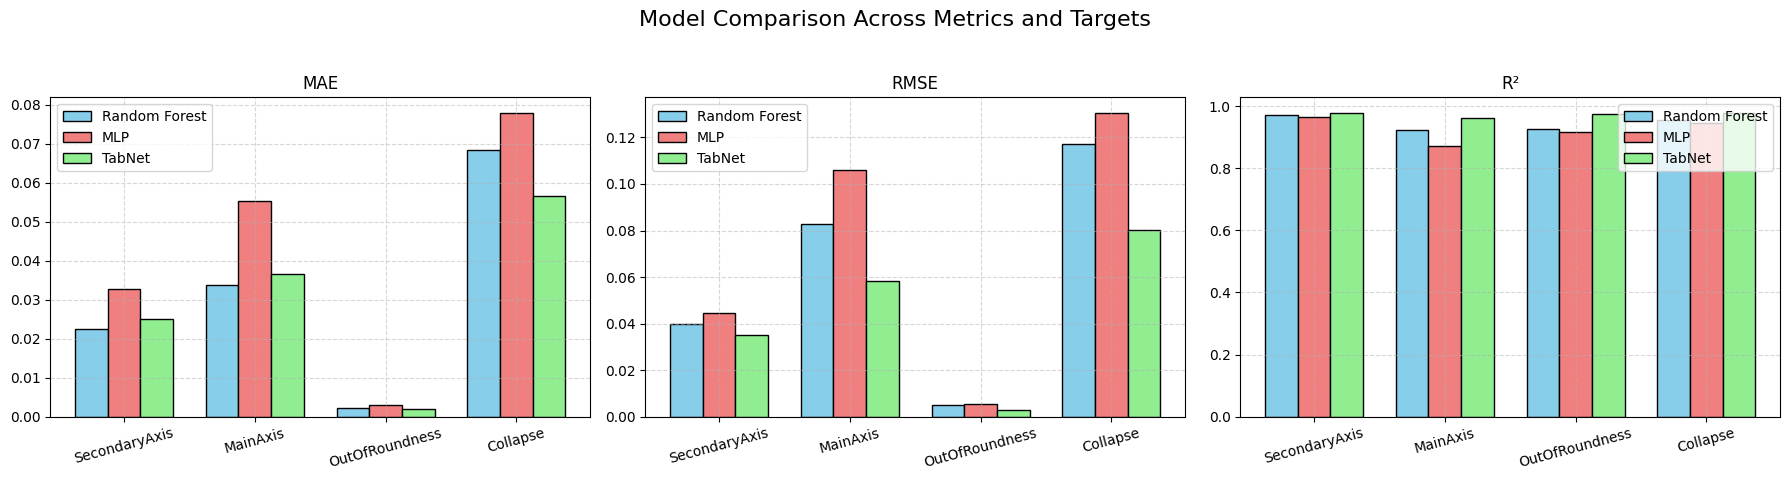

In [36]:
tabnet_metrics = result_of_all_cases['random_unseen_simulation_TabNet']

# Define the targets and metrics
targets = ['SecondaryAxis', 'MainAxis', 'OutOfRoundness', 'Collapse']
metrics = ['MAE', 'RMSE', 'R²']

x = np.arange(len(targets))  # the label locations
width = 0.25  # the width of the bars

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    rf_vals = [float(rf_metrics[target][metric]) for target in targets]
    mlp_vals = [float(mlp_metrics[target][metric]) for target in targets]
    tabnet_vals = [float(tabnet_metrics[target][metric]) for target in targets]

    ax.bar(x - width, rf_vals, width=width, label='Random Forest', color='skyblue', edgecolor='black')
    ax.bar(x, mlp_vals, width=width, label='MLP', color='lightcoral', edgecolor='black')
    ax.bar(x + width, tabnet_vals, width=width, label='TabNet', color='lightgreen', edgecolor='black')

    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(targets, rotation=15)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

fig.suptitle('Model Comparison Across Metrics and Targets', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('RF_vs_MLP_vs_TabNet.png', dpi=300, bbox_inches='tight')
plt.show()

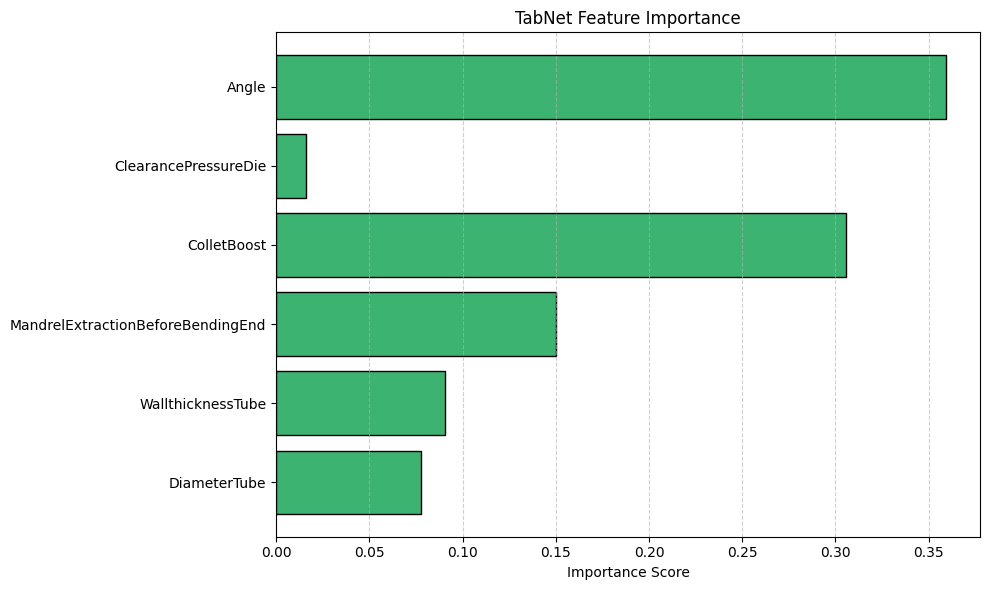

In [37]:
# Get feature importances
feature_importances = tabnet_model.feature_importances_

# Your input feature names (update if you use different ones)
feature_names = ['DiameterTube', 'WallthicknessTube', 'MandrelExtractionBeforeBendingEnd',
                 'ColletBoost', 'ClearancePressureDie', 'Angle']

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances, color='mediumseagreen', edgecolor='black')
plt.xlabel('Importance Score')
plt.title('TabNet Feature Importance')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

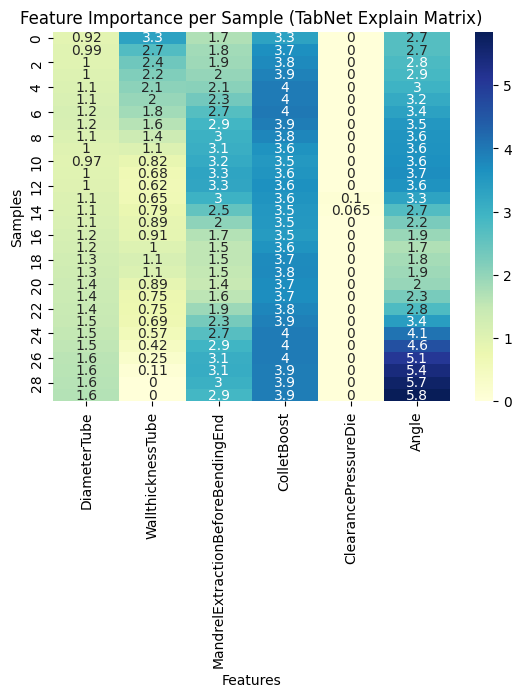

In [42]:
import seaborn as sns

explain_matrix, masks = tabnet_model.explain(X_train_np)

# Visualize explain matrix for first 10 samples
sns.heatmap(explain_matrix[:30], xticklabels=feature_names, cmap="YlGnBu", annot=True)
plt.title("Feature Importance per Sample (TabNet Explain Matrix)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()